In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
path = "/content/drive/MyDrive/ColabNotebooks/5622/p2"

os.chdir(path)
os.listdir(path)

['training',
 'validation',
 'validation.zip',
 'test.zip',
 'training.zip',
 'gt_training.csv',
 'test',
 'gt_training_new.csv']

In [ ]:
!unzip '/content/drive/MyDrive/ColabNotebooks/5622/p2/test.zip' -d '/content/drive/MyDrive/ColabNotebooks/5622/p2'
!unzip '/content/drive/MyDrive/ColabNotebooks/5622/p2/training.zip' -d '/content/drive/MyDrive/ColabNotebooks/5622/p2'
!unzip '/content/drive/MyDrive/ColabNotebooks/5622/p2/validation.zip' -d '/content/drive/MyDrive/ColabNotebooks/5622/p2'

Archive:  /content/drive/MyDrive/ColabNotebooks/5622/p2/test.zip
replace /content/drive/MyDrive/ColabNotebooks/5622/p2/test/00003.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/ColabNotebooks/5622/p2/training.zip
Archive:  /content/drive/MyDrive/ColabNotebooks/5622/p2/validation.zip


In [3]:
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import csv
import PIL
import torchvision.transforms as transforms

with open('/content/drive/MyDrive/ColabNotebooks/5622/p2/gt_training.csv', mode='r') as infile:
    heading = next(infile)
    reader = csv.reader(infile)
    label = dict({'Homogeneous': 0, 'Speckled': 1, 'Nucleolar': 2, 'Centromere': 3, 'NuMem': 4, 'Golgi': 5})
    with open('gt_training_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        mydict = dict((rows[0], label[rows[1]]) for rows in reader)



In [4]:
import re
import torch
from PIL import Image
import torchvision.transforms as transforms


training_set = []
validation_set = []
test_set = []


validationPath = r'/content/drive/MyDrive/ColabNotebooks/5622/p2/validation'
trainingPath = r'/content/drive/MyDrive/ColabNotebooks/5622/p2/training'
testPath = r'/content/drive/MyDrive/ColabNotebooks/5622/p2/test'


for filename in os.listdir(validationPath):
  image = Image.open(validationPath + '/' + filename).convert('RGB')
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224, 224)), 
      
      ])
  img_tensor = transform(image)
  input = []
  input.extend((img_tensor, mydict[(str(int(''.join(filter(str.isdigit, filename)))))]))
  validation_set.append(input)

for filename in os.listdir(trainingPath):
  image = Image.open(trainingPath + '/' +filename).convert('RGB')
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224, 224))
      
      ])
  img_tensor = transform(image)
  input = []
  input.extend((img_tensor, mydict[(str(int(''.join(filter(str.isdigit, filename)))))]))
  training_set.append(input)

for filename in os.listdir(testPath):
  image = Image.open(testPath + '/' + filename).convert('RGB')
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((224, 224))
      
      ])
  img_tensor = transform(image)
  input = []
  input.extend((img_tensor, mydict[(str(int(''.join(filter(str.isdigit, filename)))))]))
  test_set.append(input)




In [75]:
print(f'label of first image is: {training_set[0][1]}')
print((training_set[0][0]).size())

label of first image is: 4
torch.Size([3, 224, 224])


In [19]:

train_dataloader = DataLoader(training_set, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True)
val_dataloader = DataLoader(validation_set, batch_size=128, shuffle=True)


In [52]:
from os import listdir
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn
import torchvision.models as models 


In [53]:
alexnet = models.alexnet(pretrained=True)

num_fc = alexnet.classifier[6].in_features
alexnet.classifier[6] = torch.nn.Linear(in_features=num_fc, out_features=6)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.0001)
scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [7,13], gamma = 0.5)


In [26]:
def testset_precision(net, testset): 
    dl = DataLoader(testset, batch_size = 128) 
    total_count = 0 
    total_correct = 0 
    for data in dl: 
        inputs = data[0].cuda()  
        targets = data[1].cuda()
        outputs = net(inputs)    
        predicted_labels = outputs.argmax(dim=1) 
        comparison = predicted_labels == targets  
        total_count += predicted_labels.size(0)   
        total_correct += comparison.sum()      
        
    return int(total_correct) / int(total_count)

In [54]:


my_train_loss = []
my_test_acc = []
my_val_loss = []
my_val_acc = []
net = alexnet.cuda()
for epoch in range(20):  # loop over the dataset multiple times

            
    train_running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        train_running_loss += loss.item()
    scheduler1.step()
    print('The train_loss of the %d epoch is: %.3f' %
                    (epoch + 1, train_running_loss / len(train_dataloader)))
    b = testset_precision(net, validation_set)
    print(f'test set accuracy is: {b}')
    my_train_loss.append(train_running_loss / len(train_dataloader))
    my_test_acc.append(b)
print('Finished Training')

The train_loss of the 1 epoch is: 0.558
test set accuracy is: 0.8951724137931034
The train_loss of the 2 epoch is: 0.254
test set accuracy is: 0.9305747126436782
The train_loss of the 3 epoch is: 0.199
test set accuracy is: 0.9098850574712644
The train_loss of the 4 epoch is: 0.156
test set accuracy is: 0.9356321839080459
The train_loss of the 5 epoch is: 0.119
test set accuracy is: 0.9397701149425287
The train_loss of the 6 epoch is: 0.106
test set accuracy is: 0.9429885057471264
The train_loss of the 7 epoch is: 0.112
test set accuracy is: 0.952183908045977
The train_loss of the 8 epoch is: 0.052
test set accuracy is: 0.9494252873563218
The train_loss of the 9 epoch is: 0.037
test set accuracy is: 0.9595402298850575
The train_loss of the 10 epoch is: 0.031
test set accuracy is: 0.9508045977011494
The train_loss of the 11 epoch is: 0.031
test set accuracy is: 0.9641379310344828
The train_loss of the 12 epoch is: 0.023
test set accuracy is: 0.9567816091954023
The train_loss of the 13 e

validation set accuracy is: 0.9659770114942529


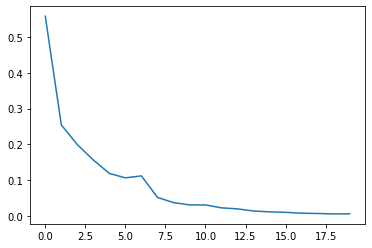

[0.8951724137931034,
 0.9305747126436782,
 0.9098850574712644,
 0.9356321839080459,
 0.9397701149425287,
 0.9429885057471264,
 0.952183908045977,
 0.9494252873563218,
 0.9595402298850575,
 0.9508045977011494,
 0.9641379310344828,
 0.9567816091954023,
 0.9549425287356322,
 0.9613793103448276,
 0.9604597701149425,
 0.9595402298850575,
 0.960919540229885,
 0.960919540229885,
 0.967816091954023,
 0.9650574712643678]

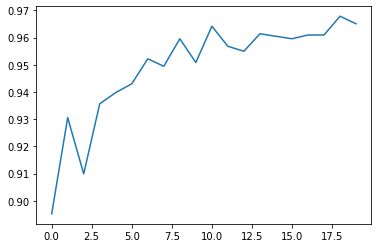

In [56]:
b = testset_precision(net, validation_set)
print(f'validation set accuracy is: {b}')

import matplotlib.pyplot as plt
plt.plot(my_train_loss,"-")

plt.show()


plt.plot(my_test_acc,"-")



my_train_loss
my_test_acc

